# Fashion Buddy Demo - Astra Vector Search and Vertex AI Gemini

### Intro
Have you ever scrolled through photo sharing websites such as Instagram or Pinterest and had your eyes set on a specific outfit but did not know where to get the items? The Fashion Buddy lets you upload a photo of any outfit and returns the most similar pieces of apparel to recreate the outfit.

### Overview
This notebook shows you how to use Vertex AI, Gemini, RAG, and Astra DB to perform vector similarity search and multi-modal Retrieval Augmented Generation (RAG)

### Before you get started
Make sure you have the following:


*   Astra DB account.
*   Vertex AI account




# Import Initial Dependencies

### Install Python dependencies

In [ ]:
!pip install google-cloud-aiplatform ragstack-ai --upgrade

### Import Packages

In [ ]:
import pandas as pd
import numpy as np
import getpass, os, requests, sys, json, vertexai
import json

# Load Credentials

### Load Astra DB and Vertex AI credentials

In [ ]:
credential_names = ["GCP_PROJECT_ID", "ASTRA_DB_ENDPOINT", "ASTRA_DB_TOKEN"]

for credential in credential_names:
  if credential not in os.environ:
     os.environ[credential] = getpass.getpass("Provide your " + credential)

Provide your GCP_PROJECT_ID··········
Provide your ASTRA_DB_ENDPOINT··········
Provide your ASTRA_DB_TOKEN··········


###Configure Google Vertex AI Credentials and Google Colab.
You should see a popup that you must authorize to use your Google Cloud account.  If a window doesn't pop up, it may be blocked by a popup blocker.

In [ ]:
from google.colab import userdata, auth, files, drive
from google.cloud import aiplatform

!gcloud config set project {os.environ["GCP_PROJECT_ID"]}

auth.authenticate_user()

Updated property [core/project].


# Import Clothing Dataset

First, we must import the dataset that we are going to be retrieving our results from.

### Read in Zara Clothing dataset

This dataset includes products from a popular clothing store, Zara. We will be using this to search against for our Fashion Buddy.

Let us first load the [Zara sample dataset from Hugging Face](https://huggingface.co/datasets/datastax/zara_embeddings_newcategories) using the Datasets library.



In [ ]:
from datasets import load_dataset

dataset = load_dataset("datastax/zara_embeddings_newcategories", split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/936 [00:00<?, ? examples/s]

In [ ]:
df = pd.DataFrame.from_dict(dataset)
df['embeddings'] = df['embeddings'].apply(json.loads) # converts embeddings into an array of vectors

In [ ]:
# Visualize dataset
df.head()

product_name                                               link  \
0         WORKOUT T-SHIRT  https://www.zara.com/in/en/workout-t-shirt-p05...   
1         SPORTS BACKPACK  https://www.zara.com/in/en/sports-backpack-p13...   
2  COMPACT COTTON T-SHIRT  https://www.zara.com/in/en/compact-cotton-t-sh...   
3    TANK TOP WITH SLOGAN  https://www.zara.com/in/en/tank-top-with-sloga...   
4          TRAINING SOCKS  https://www.zara.com/in/en/training-socks-p024...   

                                      product_images  price  \
0  https://static.zara.net/photos///2023/I/0/2/p/...  32.06   
1  https://static.zara.net/photos///2023/I/1/2/p/...  64.26   
2  https://static.zara.net/photos///2023/I/0/2/p/...  32.06   
3  https://static.zara.net/photos///2023/I/0/2/p/...  27.86   
4  https://static.zara.net/photos///2023/I/0/2/p/...  13.86   

                                             details    category gender  \
0  T-shirt made of lightweight textured stretch f...  ACTIVEWEAR    men   
1  Multi-pocket backpack. Combination of material...  ACTIVEWEAR    men   
2  Loose-fitting T-shirt made of compact cotton. ...  ACTIVEWEAR    men   
3  Loose-fitting T-shirt made of cotton. Round ne...  ACTIVEWEAR    men   
4  Pack of 2 pairs of seamless mesh socks with ri...  ACTIVEWEAR    men   

                                          embeddings  
0  [0.00584839704, 0.00366304931, 0.0416106768, 0...  
1  [0.00701390672, 0.00680825347, 0.0142998686, 0...  
2  [0.0323305465, 0.0137906792, 0.0440658815, 0.0...  
3  [-0.0316199474, -0.0126086716, 0.036310371, 0....  
4  [0.0402002, -0.0139389914, 0.0203817375, 0.007...

# Use Vertex AI multimodal to create embeddings
This code block is for demonstration purposes. There is no need to run this block since the provided dataset already has Gemini embeddings included.

In [ ]:
from vertexai.preview.vision_models import MultiModalEmbeddingModel, Image

vertexai.init(project=os.getenv("GCP_PROJECT_ID"))
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

# Generate and add the embeddings to the dataframe
def add_embeddings(df):
  for i in range(len(df)):
    if pd.isnull(df.loc[i, 'embeddings']).all():
      # Create Image from URL
      img_bytes = requests.get(df.loc[i, "product_images"]).content
      img = Image(img_bytes)
      # Create embedding based on Image
      cur_embeddings = model.get_embeddings(
          image = img,
          contextual_text = df.loc[i, 'product_name'])
      df.loc[i, 'embeddings'] = cur_embeddings.image_embedding

add_embeddings(df)

In [ ]:
# visualize embeddings
print(df['embeddings'])

0      [0.00584839704, 0.00366304931, 0.0416106768, 0...
1      [0.00701390672, 0.00680825347, 0.0142998686, 0...
2      [0.0323305465, 0.0137906792, 0.0440658815, 0.0...
3      [-0.0316199474, -0.0126086716, 0.036310371, 0....
4      [0.0402002, -0.0139389914, 0.0203817375, 0.007...
                             ...                        
931    [-0.00128519745, 0.0214543939, -0.017215874, 0...
932    [-0.0119625367, 0.0301359948, 0.00924325548, -...
933    [-0.0016312066, 0.0362093411, -0.0134104919, 0...
934    [-0.0242678728, 0.0520862266, -0.0203515608, -...
935    [0.00251726038, 0.0192809049, 0.0133056529, -0...
Name: embeddings, Length: 936, dtype: object


# Load Data into Astra DB

Now we'll initialize our Astra vector database, create the vector embeddings of each clothing product from the dataset that we loaded in using Google's Multi-Modal Embedding Model, then save it back to Astra DB.

In [ ]:
from astrapy.db import AstraDB, AstraDBCollection

# Connect to our vector database
astra_db = AstraDB(
    token=os.getenv("ASTRA_DB_TOKEN"),
    api_endpoint=os.getenv("ASTRA_DB_ENDPOINT"))

# Creating new collection
collection = astra_db.create_collection(
  collection_name="fashion_buddy_workshop",
  dimension=1408)

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display

# Load to vector store
def load_to_astra(df, collection):
  len_df = len(df)
  f = IntProgress(min=0, max=len_df) # instantiate the bar
  display(f) # display the bar
  for i in range(len_df):
    f.value += 1 # signal to increment the progress bar
    f.description = str(f.value) + "/" + str(len_df)

    # Store columns from pandas dataframe into Astra
    product_name = df.loc[i, "product_name"]
    link = df.loc[i, "link"]
    product_images = df.loc[i,"product_images"]
    price = df.loc[i, "price"]
    details = df.loc[i, "details"]
    category = df.loc[i, "category"]
    gender = df.loc[i, "gender"]
    embeddings = df.loc[i, "embeddings"]

    try:
      # add to the Astra DB Vector Database using insert_one statement
      collection.insert_one({
          "_id": i,
          "product_name": product_name,
          "link": link,
          "product_images": product_images,
          "price": price,
          "details": details,
          "category": category,
          "gender": gender,
          "$vector": embeddings,
        })
    except Exception as error:
      # if you've already added this record, skip the error message
      error_info = json.loads(str(error))
      if error_info[0]['errorCode'] == "DOCUMENT_ALREADY_EXISTS":
        print("Document already exists in the database. Skipping.")

load_to_astra(df, collection)

IntProgress(value=0, max=936)

# Define functions for providing product recommendations
Here we are defining all of our helper functions for the main actions needed in our app.

In [ ]:
# Takes an image (URL or image file) and returns it
def get_image(image_source):
  if image_source.startswith('http://') or image_source.startswith('https://'):
    img_bytes = requests.get(image_source).content
    img = Image(img_bytes)
    return img
  else:
    img = Image.load_from_file(image_source)
    return img

# Gets image embeddings using Google Gemini model
def get_img_embeddings(img, text=""):
  embeddings = model.get_embeddings(
      image=img,
      contextual_text=text # passes text along with the image (multimodal)
  )
  return embeddings.image_embedding

# Displays recommendations by category returned by Astra Vector Search
def show_recommendations(documents, category=None):
  if category:
    print()
    print("Category:", category)
  for doc in documents:
    print(doc["product_name"], "$" + str(doc["price"]), ", Gender:", doc["gender"])
    print(doc["details"])
    print(doc["link"])
    print("Similarity score: ", doc["$similarity"])

# Finds the similar items of the given reference image and categories (if any) along with a search prompt to give the model context
def find_similar_items(reference_image, categories=None):
  reference_img = get_image(reference_image)
  print("Reference image:")
  reference_img.show()
  print("Selected categories:", ", ".join(categories) if categories else "None")
  if categories:
    for category in categories:
      # Run multiple ANN searches to pull top 3 matches
      # for each category requested
      search_prompt = """
        I am trying to find pieces of apparel that are similar to what is in this
        picture. Ignore the model and only focus on finding the most similar clothing.

        I only care about apparel that falls within the category contained
        within triple backticks:

        ```{category}```
      """.format(category=category)
      reference_embeddings = get_img_embeddings(reference_img, text=search_prompt)
      # Run an ANN search filtering by apparel category
      documents = collection.vector_find(
          reference_embeddings,
          limit=3,
          filter={"category": category},
          include_similarity=True
      )
      show_recommendations(documents, category=category)
  else:
    search_prompt = """
      I am trying to find pieces of apparel that are similar to what is in this
      picture. Pretend as if there is no model in the image, only clothing.
    """
    reference_embeddings = get_img_embeddings(reference_img, text=search_prompt)
    # Run single ANN search across entire DB
    documents = collection.vector_find(
      reference_embeddings,
      limit=3
    )
    show_recommendations(documents)

# Example Time!
Let's run a couple of examples to see our work above in action.

### Example 1 - Query from file upload (without categories)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving example-outfit (1).jpeg to example-outfit (1).jpeg


Reference image:


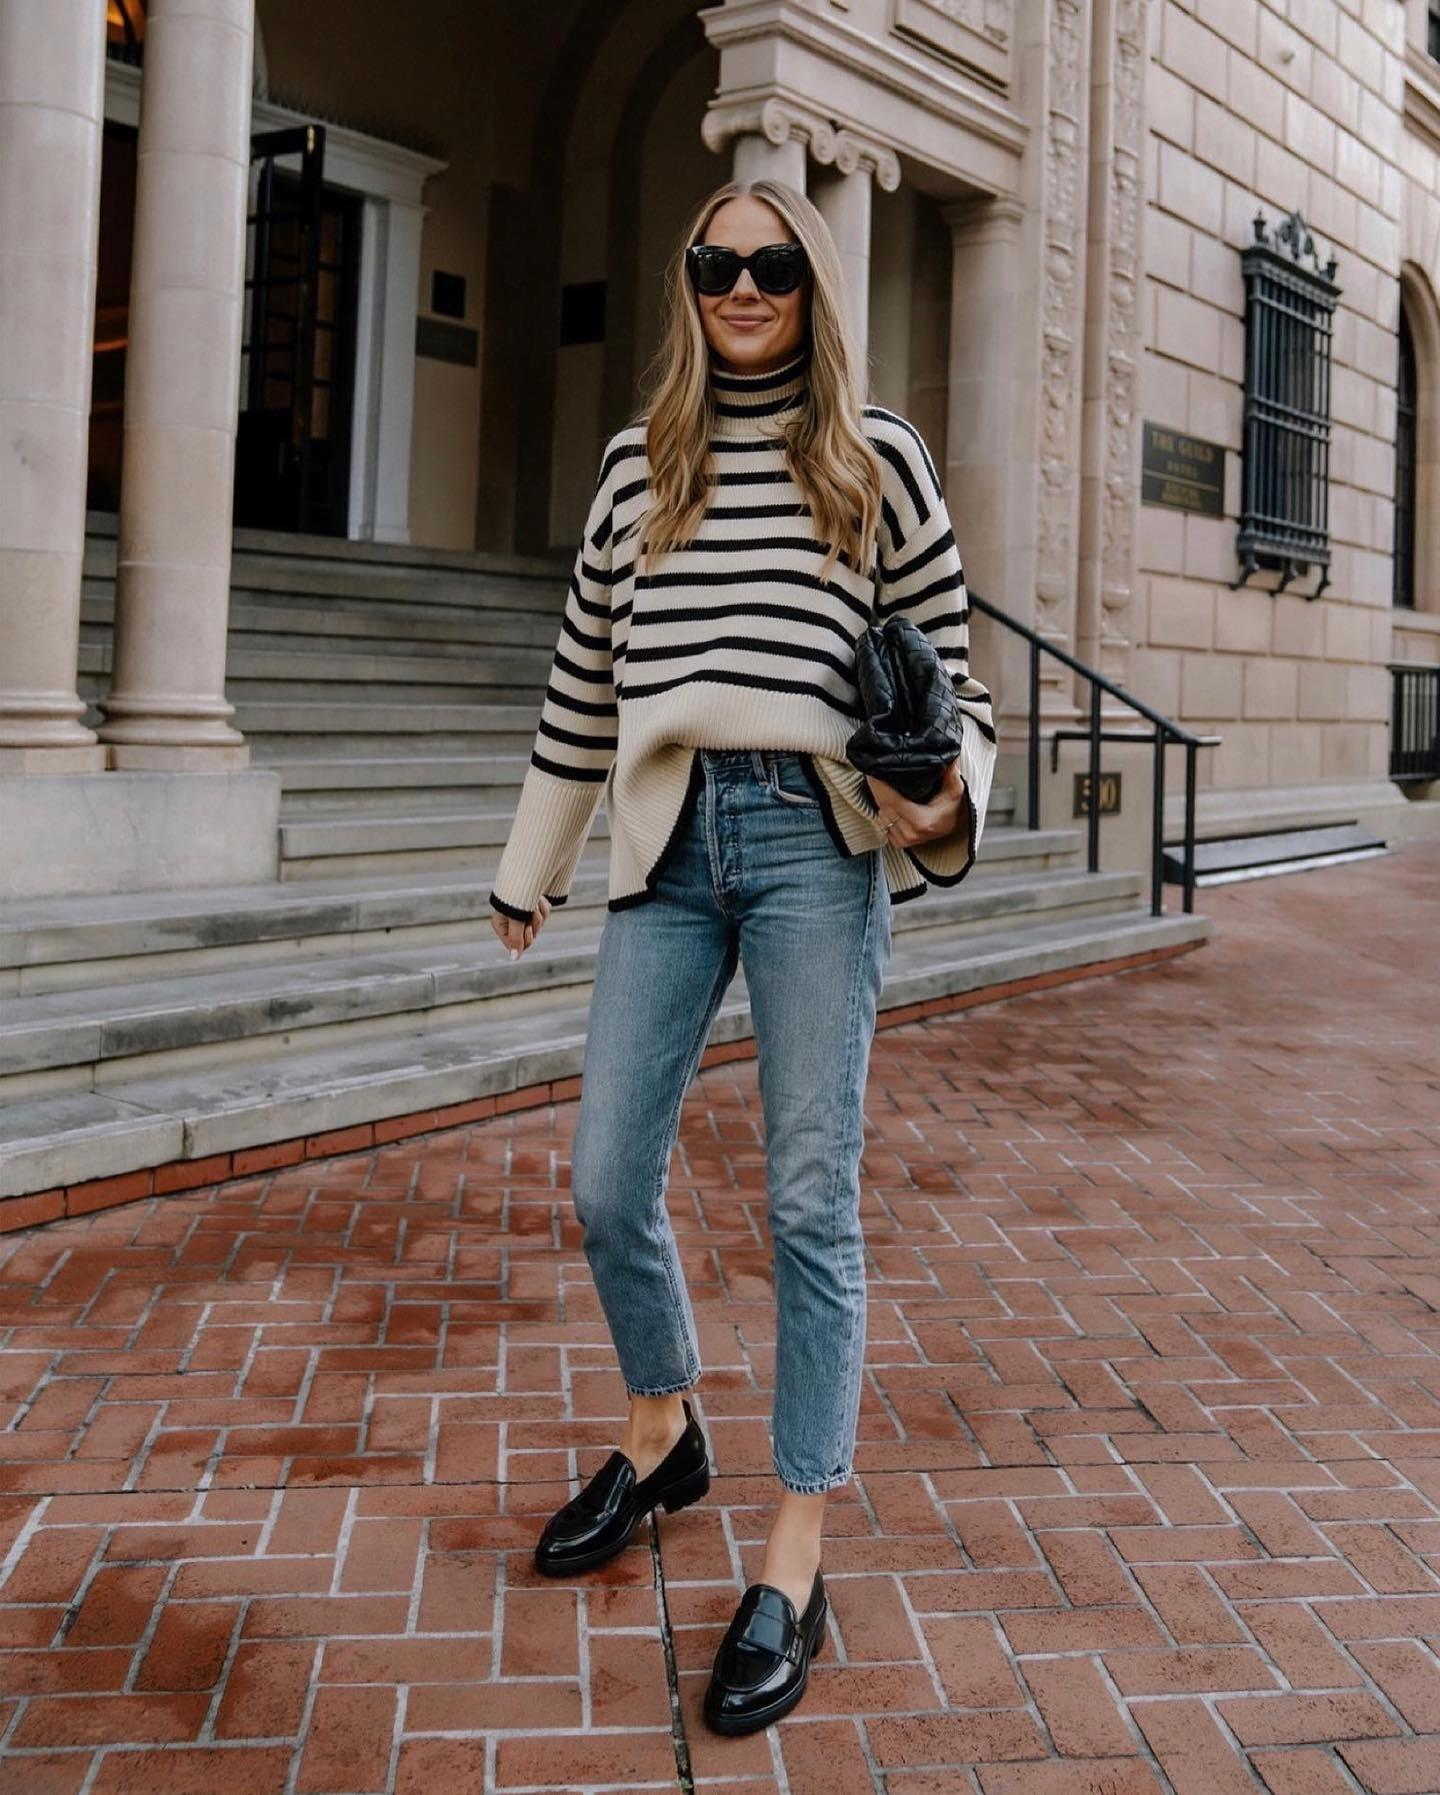

Selected categories: None
HIGH-HEEL MULES $40.46 , Gender: women
High-heel mules. Pointed toe.Heel height: 6 cm. / 2.3″AIRFIT®. Flexible technical latex foam insole, designed to offer greater comfort.View more
https://www.zara.com/in/en/high-heel-mules-p13201210.html
Similarity score:  0.7688427
MINI CITY BAG $40.46 , Gender: women
Mini city bag. Top handles and adjustable and crossbody shoulder strap. Zip closure. Inner pouch with gathered drawstring closure.Height x Length x Width 16 x 22 x 7,5 cm. / 6.2 x 8.6 x 2.9″View more
https://www.zara.com/in/en/mini-city-bag-p16041210.html
Similarity score:  0.75861454
FABRIC CROSSBODY BAG $36.26 , Gender: women
Fabric crossbody bag. Adjustable fabric crossbody strap. Zip closure.Height x Length x Width 12 x 31 x 12 cm. / 4.7 x 12.2 x 4.7″
https://www.zara.com/in/en/fabric-crossbody-bag-p16701210.html
Similarity score:  0.7534043


In [ ]:
reference_image = "/content/example-outfit (1).jpeg"
find_similar_items(reference_image)

## Let's see these results in Astra DB

Here we are getting the image embedding and replicating the actual vector search in our Astra DB UI.


In [ ]:
print(get_img_embeddings(get_image("/content/example-outfit (1).jpeg"), ""));

[0.00405547163, 0.0126129827, 0.0229031667, -0.0186599251, 0.00398824224, 0.00652303593, -6.85976484e-05, 0.0113469614, -0.0232348628, -0.0370625369, -0.0104567437, 0.0359334387, -0.0185136106, 0.1362091, -0.022922419, 0.00972669, -0.0239761136, -0.0141025549, 0.0152499415, -0.0143603934, 0.0809043869, -0.0082462281, 0.0104210544, -0.0199185554, -0.00681403326, -0.0228260309, 0.00199514697, -0.00642385753, -0.0153334588, -0.0371538289, -0.0169792548, -0.00579003338, 0.0110038882, -0.0206940267, -0.0304744188, -0.00244443654, -0.0240258221, 0.00632777, -0.00972419, -0.0116717285, -0.0339958742, 0.00959436409, -0.00946252, -0.00951092876, -0.00731731812, 0.0034981959, -0.0123784188, -0.0131145, 0.0168825649, 7.70260594e-05, 0.0446989946, -0.0230653454, -0.00517983548, -0.00410867715, 0.0269666854, -0.0129054794, -0.0369583666, -0.0285039824, 0.00656602718, -0.015203286, -0.0286717471, 0.00830423459, 0.00380950072, -0.00808194187, -0.0502409078, 0.00519684097, 0.00420984393, 0.0574046858,

### Example 2 - Query from URL (with categories)

Reference image:


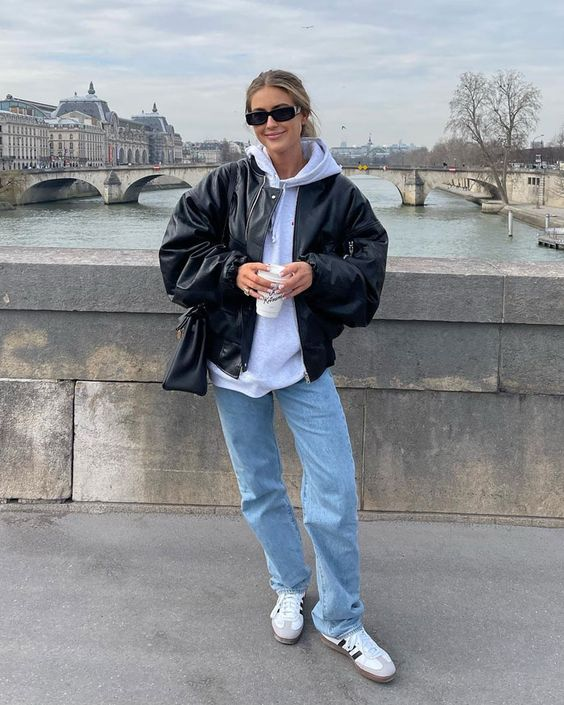

Selected categories: TOPS, BOTTOMS, OUTERWEAR

Category: TOPS
LONG BOMBER JACKET $78.26 , Gender: women
Long bomber jacket with a lapel collar. Long sleeves with elasticated cuffs. Front welt pockets. Matching lining. Elasticated hem. Button-up front hidden by a placket.
https://www.zara.com/in/en/long-bomber-jacket-p09929228.html
Similarity score:  0.77000034
CROPPED PUFFER BOMBER JACKET $46.06 , Gender: women
Jacket featuring a round neck and long sleeves with cuffs. Jetted pockets on the front. Front snap-button fastenings.
https://www.zara.com/in/en/cropped-puffer-bomber-jacket-p03046227.html
Similarity score:  0.7651411
HOODIE $46.06 , Gender: men
Hoodie made of cotton with a napped interior. Adjustable hood and long sleeves. Front pouch pocket and ribbed trims.
https://www.zara.com/in/en/hoodie-p00761350.html
Similarity score:  0.74478203

Category: BOTTOMS
CARGO PARACHUTE TROUSERS $69.86 , Gender: men
Relaxed fit trousers made of textured ripstop fabric that is resistant to tear

In [ ]:
reference_image = "https://i.pinimg.com/564x/47/18/81/4718815109cd59904c109b734c27ed4a.jpg"
categories = ["TOPS", "BOTTOMS", "OUTERWEAR"]

find_similar_items(reference_image, categories=categories)

### Example 3 - Same query without categories

Reference image:


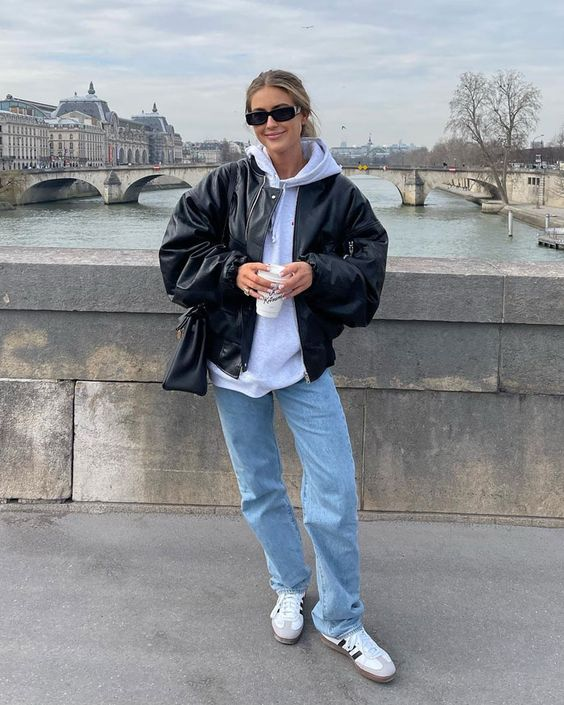

Selected categories: None
HOODED BOMBER JACKET $106.26 , Gender: men
Varsity jacket with a hood in the collar. Long sleeves with elasticated cuffs. Jetted pockets at the hip and inside pocket detail. Contrast patches and embroidery on the front and back. Ribbed trims. Snap-button front.
https://www.zara.com/in/en/hooded-bomber-jacket-p03833407.html
Similarity score:  0.7769455
JACKET WITH MAO COLLAR $83.86 , Gender: men
Jacket made of a cotton blend fabric. High neck and long sleeves. Hip welt pockets. Ribbed trims. Zip fastening on the front.
https://www.zara.com/in/en/jacket-with-mao-collar-p06518300.html
Similarity score:  0.7728741
CROPPED COTTON WAXED JACKET $69.86 , Gender: women
Jacket made of waxed fabric. Lapel collar and long cuffed sleeves. Front pockets. Elastic hem at the back. Front fastening with metal zip.
https://www.zara.com/in/en/cropped-cotton-waxed-jacket-p04341738.html
Similarity score:  0.7664012


In [ ]:
reference_image = "https://i.pinimg.com/564x/47/18/81/4718815109cd59904c109b734c27ed4a.jpg"
find_similar_items(reference_image)